<a href="https://colab.research.google.com/github/Ridha273/pulsar-glitch/blob/main/crab_pulsar_timing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Initialising

In [ ]:
import pandas as pd
import numpy as np
import astropy
import matplotlib.pyplot as plt

In [ ]:
from lmfit.models import LinearModel

def linfit(x,y):

    linear_model = LinearModel(prefix='line_')
    linear_params = linear_model.make_params()
    linear_params['line_slope'].set(value=1.0)
    linear_params['line_intercept'].set(value=0.0)

    linear_fit = linear_model.fit(y, linear_params, x=x)

    m = linear_fit.params['line_slope'].value
    c = linear_fit.params['line_intercept'].value

    fit_values = linear_fit.eval_components(x=x)
    return m,c,fit_values['line_']

In [ ]:
from lmfit.models import PolynomialModel

def polyfit(x,y):
    
    poly_model = PolynomialModel(2, prefix='poly_')
    poly_params = poly_model.make_params()
    poly_params['poly_c0'].set(value=1.0)
    poly_params['poly_c1'].set(value=1.0)
    poly_params['poly_c2'].set(value=1.0)

    poly_fit = poly_model.fit(y, poly_params, x=x)
    fit_values = poly_fit.eval_components(x=x)
    return fit_values['poly_']

In [ ]:
from lmfit.models import PowerLawModel

def powfit(x,y):
    
    pl_model = PowerLawModel(prefix='pl_')
    pl_params = pl_model.make_params()
    pl_params['pl_amplitude'].set(value=1.0)
    pl_params['pl_exponent'].set(value=-2.5)
    pl_fit = pl_model.fit(y, pl_params, x=x)
    fit_values = pl_fit.eval_components(x=x)
    a = pl_fit.params['pl_exponent'].value
    return a,fit_values['pl_']

In [ ]:
from astropy.io import ascii
data = ascii.read('timing-data')
print(data)

   Date    MJD  t_JPL_sec t_acc_usec ... nudot_10-15sec-2 sigma_nudot DM_pccm-3
--------- ----- --------- ---------- ... ---------------- ----------- ---------
15-FEB-82 45015  0.021592        100 ...       -381008.75        0.92    56.834
15-MAR-82 45043  0.018609        100 ...       -380959.78        0.55    56.837
15-APR-82 45074  0.026111         50 ...        -380937.4        1.57     56.83
15-MAY-82 45104  0.007626         50 ...       -380908.68        0.96    56.818
15-JUN-82 45135  0.020887        600 ...       -380834.54        5.26    56.836
15-JUL-82 45165  0.009312         60 ...        -380820.2        0.57    56.823
15-AUG-82 45196  0.024812         50 ...       -380800.04        1.26     56.82
15-SEP-82 45227  0.032439        200 ...       -380788.69        0.89    56.822
15-OCT-82 45257  0.007598        200 ...       -380754.71        0.29    56.821
15-NOV-82 45288   0.00868         50 ...       -380712.11        0.59    56.825
      ...   ...       ...        ... ...

## Period, Age, Braking Index

In [ ]:
freq = data['nu_Hz']
time = data['MJD']
period =  1/freq
fdot = data['nudot_10-15sec-2']*10**-15
pdot = -(period**2)*fdot

Text(0, 0.5, 'P (s)')

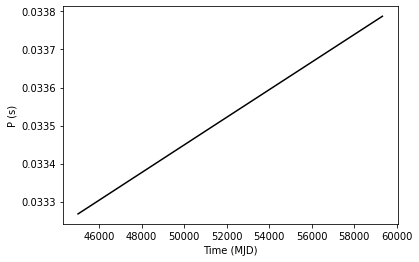

In [ ]:
plt.plot(time, period, color='black',label='Observed')
plt.xlabel('Time (MJD)')
plt.ylabel('P (s)')

Text(0, 0.5, '$\\dot{P}$ (ss$^{-1})$')

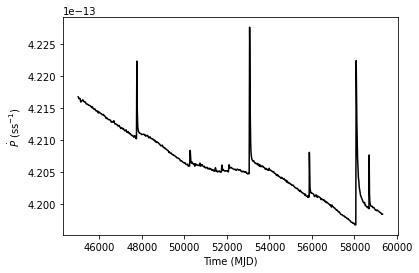

In [ ]:
plt.plot(time, pdot, color='black')
plt.xlabel('Time (MJD)')
plt.ylabel(r'$\dot{P}$ (ss$^{-1})$')

Text(0, 0.5, '$\\dot{\\nu}$ (s$^{-2})$')

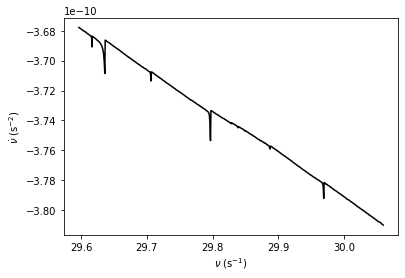

In [ ]:
plt.plot(freq, fdot, color='black')
plt.xlabel(r'$\nu$ (s$^{-1}$)')
plt.ylabel(r'$\dot{\nu}$ (s$^{-2})$')

In [ ]:
n,vdotdot = powfit(freq,fdot)
dn = n*((data['sigma_nu']/freq)+(data['sigma_nudot']*(10**(-15))/fdot))
dn = np.mean(dn)
print('Braking index:',n,dn)

Braking index: 2.240413169657609 0.2544960188298084


In [ ]:
age = period/(2*pdot)
age = age/(60*60*24*365.25)
print('Characteristic age:',np.mean(age))

Characteristic age: 1263.1008704462658


# Largest Glitch

In [ ]:
time = data['MJD']
j = np.where(time == 58068)
i = int(j[0])
f = fdot
time = np.arange(len(f))
time = data['MJD']


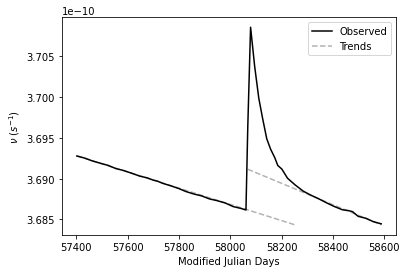

In [ ]:
plt.plot(time[i-24:i+24], abs(f[i-24:i+24]), color='black', label = 'Observed')

m0,c0,fit0 = linfit(time[i-24:i-12], abs(f[i-24:i-12]))
y = [(m0*x)+c0 for x in time[i-24:i+12]]
plt.plot(time[i-24:i+12], y, 'k--', alpha = 0.3, label = 'Trends')

m1,c1,fit1 = linfit(time[i+12:i+24], abs(f[i+12:i+24]))
y = [(m1*x)+c1 for x in time[i:i+24]]
plt.plot(time[i:i+24], y, 'k--', alpha = 0.3)

plt.xlabel('Modified Julian Days' )
plt.ylabel(r'$\nu$ $(s^{-1})$')
plt.legend()

## Step function

In [ ]:
from astropy.io import ascii
glitches = ascii.read('glitches-obs')

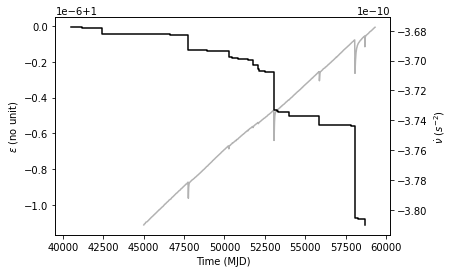

In [ ]:
e = 1
E = []
t = glitches['MJD']
de = glitches['dF/F']*10**(-9)

for i in de:
    e = e-i
    E.append(e)

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
a = ax1.step(t, E, where='post', color='black', label=r'$\epsilon$')
b = ax2.plot(time, fdot, color='black', alpha=0.3, label=r'$\dot{\nu}$')

ax1.set_xlabel('Time (MJD)')
ax1.set_ylabel(r'$\epsilon$ (no unit)')
ax2.set_ylabel(r'$\dot{\nu}$ ($s^{-2}$)')
lns = a+b
labs = [l.get_label() for l in lns]